# EDA do modelo salvo com legenda e descrição gerada com LLM

## Carregando modelo já pré-computado

In [ ]:
# Imports
from pathlib import Path
import pandas as pd, random, numpy as np
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS as STOP_PT


# Semente para compoenentes pseudo-aleatórios
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# Diretorios
ROOT = Path('../')
DATA_DIR   = ROOT / 'data'
MODEL_DIR  = ROOT / 'models'/ 'expr_bertopic_profiap'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# Carregar dados e pré-processamento
CSV_PATH = DATA_DIR / 'raw' / 'dissertacoes_profiap_14_23.csv'  # ajuste se precisar
df = pd.read_csv(CSV_PATH).drop_duplicates("DS_RESUMO")
docs = df["DS_RESUMO"].fillna("").tolist()
nlp  = spacy.load('pt_core_news_sm', disable=['ner', 'parser'])
def preprocess(doc):
    return ' '.join([t.lemma_.lower() for t in nlp(doc) if t.is_alpha and not t.is_stop])
docs_pp = [preprocess(d) for d in docs]

emb_model = SentenceTransformer("ibm-granite/granite-embedding-278m-multilingual", trust_remote_code=True)
embeddings = emb_model.encode(docs_pp, show_progress_bar=True)

topic_model = BERTopic.load(MODEL_DIR / 'model_final_gpt_labels', embedding_model=emb_model)

/home/th/.cache/pypoetry/virtualenvs/bertopic-profiap-TFdnyCro-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Batches: 100%|██████████| 40/40 [00:22<00:00,  1.77it/s]


# Datamapplot com legendas de LLM

<InteractiveFigure width=1200 height=750>
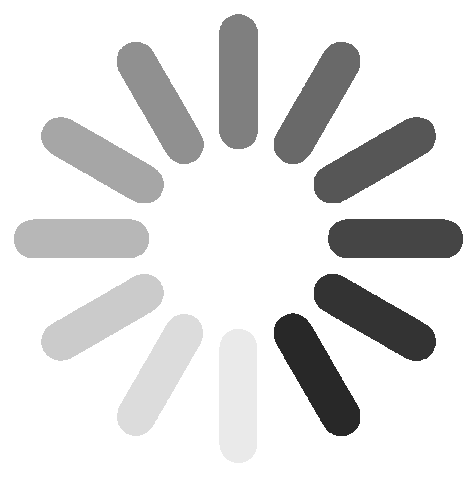

In [2]:
topic_model.set_topic_labels([item[0] for item in topic_model.get_topic_info().gpt_label])

# Visualizações
datamap = topic_model.visualize_document_datamap(
    docs=docs_pp,
    embeddings=embeddings,
    interactive=True,
    enable_search=True,
    custom_labels=True,
    title="Mapa das Dissertações PROFIAP (2015-2023)",
)
datamap

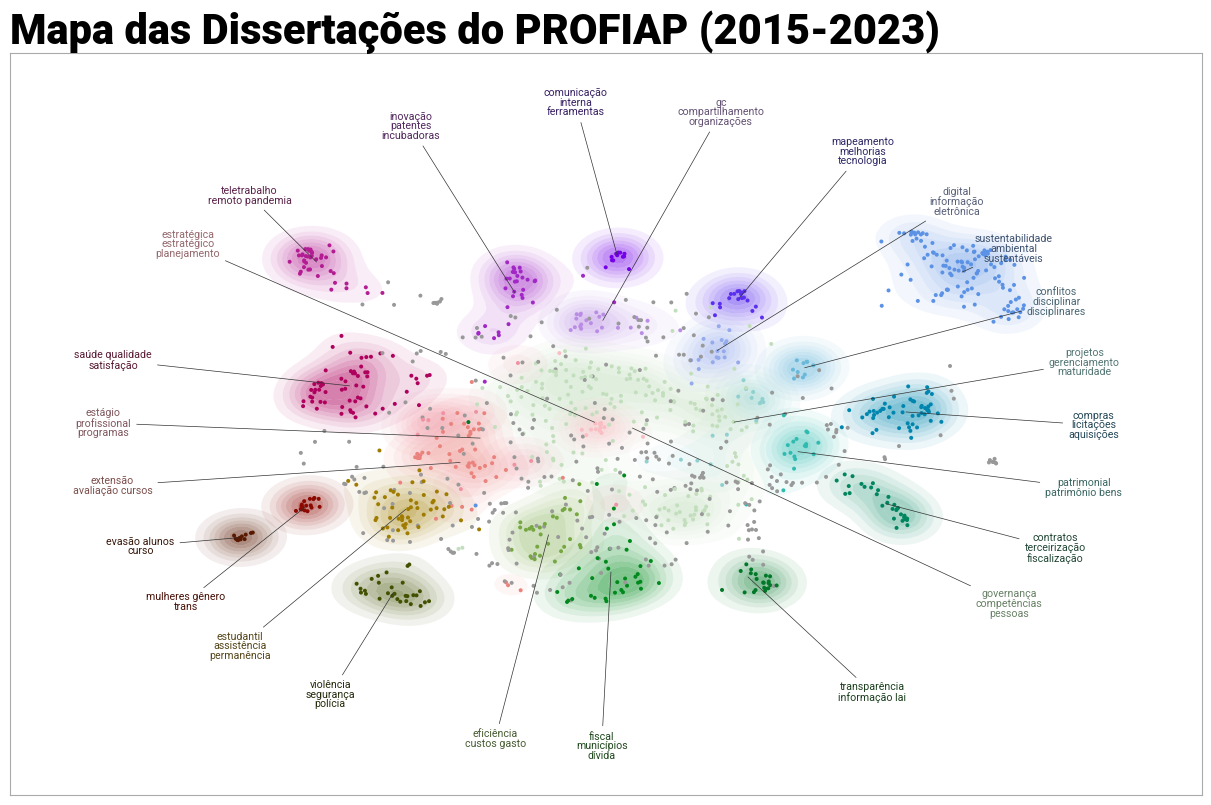

In [4]:
datamap = topic_model.visualize_document_datamap(
    docs=docs_pp,
    embeddings=embeddings,
    interactive=False,
    enable_search=False,
    custom_labels=False,
    title="Mapa das Dissertações do PROFIAP (2015-2023)",
)


In [ ]:
# Tabela de Representações utilizando LLM
tab_rep_llm = topic_model.get_topic_info()[['Topic', 'Count', 'Representation', 'gpt_label']][1:].set_index('Topic')
tab_rep_llm.columns = ['quantidade','palavras-chave','gpt_label']
tab_rep_llm

In [10]:
topic_info = topic_model.get_topic_info()
latex_output = []


for _, row in topic_info.iterrows():
    topic_num = row['Topic']
    name = row['CustomName'] if pd.notna(row['CustomName']) else row['gpt_label']
    keywords = ", ".join(row['Representation'])
    description = row['gpt_descrição']
    count = row['Count']
    
    latex_output.append(f"\\subsection*{{Tópico {topic_num} - {name}}}")
    latex_output.append(f"\\textbf{{Número de documentos:}} {count}\\\\")
    latex_output.append(f"\\textbf{{Palavras-chave:}} {keywords}.")
    latex_output.append("")
    latex_output.append(description)
    latex_output.append("")

# Unir tudo em um único texto LaTeX
latex_text = "\n".join([str(item) for item in latex_output])

print(latex_text)

\subsection*{Tópico -1 - Gestão Pública e Avaliação Desempenho}
\textbf{Número de documentos:} 322\\
\textbf{Palavras-chave:} serviços, desempenho, planejamento, eficiência, contas, informação, avaliação, qualidade, lei, pessoas.

['O presente tópico aborda a gestão e avaliação de serviços públicos, enfatizando a eficiência, qualidade e planejamento no âmbito das instituições e organizações, com foco em áreas como saúde e educação. Através da análise de desempenho e implementação de ferramentas de controle, busca-se garantir a accountability e acessibilidade das informações, além de promover melhorias nas práticas administrativas e na relação entre órgãos governamentais e cidadãos. A pesquisa explora a eficácia da legislação vigente e os impactos das políticas públicas, bem como os desafios enfrentados por municípios e entidades na execução orçamentária e prestação de serviços.']

\subsection*{Tópico 0 - Governança e Gestão de Competências}
\textbf{Número de documentos:} 201\\
\textbf{

In [15]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,gpt_label,gpt_descrição,MMR,Representative_Docs
0,-1,322,-1_controle_serviços_social_desempenho,"[controle, serviços, social, desempenho, polít...",[Gestão Pública e Avaliação Desempenho],[O presente tópico aborda a gestão e avaliação...,"[serviços, desempenho, planejamento, serviço, ...",[accountability controle social ganhado destaq...
1,0,739,0_desenvolvimento_modelo_avaliação_compras,"[desenvolvimento, modelo, avaliação, compras, ...",[Governança e Gestão de Competências],[O tópico aborda a governança e gestão de comp...,"[governança, competências, qualidade, organiza...",[tema qualidade vida trabalho qvt presente dis...
2,1,41,1_transparência_informação_acesso_eletrônico,"[transparência, informação, acesso, eletrônico...",[compras públicas e sustentabilidade ambiental],[O tópico aborda a sustentabilidade em institu...,"[sustentabilidade, ambiental, sustentáveis, su...",[direito acesso informação pública diretamente...
3,2,41,2_teletrabalho_remoto_pandemia_produtividade,"[teletrabalho, remoto, pandemia, produtividade...",[Comprometimento e Qualidade de Vida],[O tópico aborda a pesquisa sobre comprometime...,"[saúde, qualidade, qvt, fatores, trabalhadores...",[teletrabalho largamente adotado empresas priv...
4,3,29,3_violência_segurança_polícia_homicídios,"[violência, segurança, polícia, homicídios, po...",[Avaliação e Extensão Universitária],[O tópico abrange a avaliação e a extensão uni...,"[extensão, avaliação, programa, universitária,...",[violência gênero longo tornando problema orde...
5,4,29,4_conflitos_mapeamento_disciplinar_disciplinares,"[conflitos, mapeamento, disciplinar, disciplin...",[Eficiência em Compras Públicas],"[O tópico abrange a análise das compras, licit...","[licitações, aquisições, contratações, licitaç...",[business process management bpm disciplinas g...
6,5,17,5_mulheres_gênero_trans_representação,"[mulheres, gênero, trans, representação, heter...",[Avaliação da Assistência Estudantil],[O tópico abrange a análise das políticas públ...,"[estudantil, assistência, programa, pnaes, ben...",[estudo investiga ocorrência fenômeno teto vid...
7,6,14,6_estratégica_estratégico_planejamento_balanced,"[estratégica, estratégico, planejamento, balan...",[Teletrabalho na Administração Pública],"[O tópico aborda o fenômeno do teletrabalho, u...","[teletrabalho, pandemia, desvantagens, híbrido...",[planejamento estratégico sendo adotado instit...
8,7,14,7_evasão_alunos_curso_cursos,"[evasão, alunos, curso, cursos, evadidos, grad...",[Finanças Municipais e Endividamento],[O tópico aborda a gestão fiscal e financeira ...,"[fiscal, municípios, contribuintes, despesas, ...",[dados censo educação superior indicadores des...
9,8,12,8_comunicação_organizacional_ferramentas_organ...,"[comunicação, organizacional, ferramentas, org...",[Inovação e Políticas Públicas],[O tópico aborda a importância da inovação e d...,"[inovação, patentes, incubadoras, tecnológica,...",[universidades organizações formais destacam a...


In [17]:
hierarchical_topics = topic_model.hierarchical_topics(docs_pp)
hierarchical_visualization = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

hierarchical_tree = topic_model.get_topic_tree(hierarchical_topics)
hierarchical_tree

100%|██████████| 8/8 [00:00<00:00, 500.42it/s]


'.\n├─desenvolvimento_modelo_avaliação_qualidade_superior\n│    ├─■──comunicação_organizacional_ferramentas_organizações_construção ── Topic: 8\n│    └─desenvolvimento_modelo_avaliação_qualidade_superior\n│         ├─desenvolvimento_modelo_avaliação_qualidade_desempenho\n│         │    ├─■──teletrabalho_remoto_pandemia_produtividade_modalidade ── Topic: 2\n│         │    └─desenvolvimento_modelo_avaliação_compras_qualidade\n│         │         ├─desenvolvimento_modelo_avaliação_compras_qualidade\n│         │         │    ├─■──conflitos_mapeamento_disciplinar_disciplinares_melhoria ── Topic: 4\n│         │         │    └─■──desenvolvimento_modelo_avaliação_compras_qualidade ── Topic: 0\n│         │         └─■──transparência_informação_acesso_eletrônico_lai ── Topic: 1\n│         └─■──estratégica_estratégico_planejamento_balanced_scorecard ── Topic: 6\n└─evasão_mulheres_violência_segurança_alunos\n     ├─mulheres_violência_segurança_gênero_polícia\n     │    ├─■──violência_segurança_pol

In [18]:
barchart = topic_model.visualize_barchart(top_n_topics=4, n_words=10,autoscale=True)

topics_over_time = topic_model.topics_over_time(docs_pp, timestamps=df['AN_BASE'],)
topics_over_time_visualization = topic_model.visualize_topics_over_time(topics_over_time)

hierarchical_topics = topic_model.hierarchical_topics(docs_pp)
hierarchical_visualization = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

hierarchical_tree = topic_model.get_topic_tree(hierarchical_topics)

100%|██████████| 23/23 [00:00<00:00, 259.80it/s]


In [ ]:
topic_model.visualize_barchart(topics=range(0,4), n_words=10,autoscale=True, width=350, height=300)


In [ ]:
topic_model.visualize_barchart(topics=range(4,8), n_words=10,autoscale=True, width=350, height=300)


In [38]:
topic_model.visualize_barchart(topics=range(8,12), n_words=10,autoscale=True, width=350, height=300)


In [39]:
topic_model.visualize_barchart(topics=range(12,16), n_words=10,autoscale=True, width=350, height=300)


In [40]:
topic_model.visualize_barchart(topics=range(16,20), n_words=10,autoscale=True, width=350, height=300)


In [ ]:
topic_model.visualize_barchart(topics=range(20,24), n_words=10,autoscale=True, width=350, height=300)topic_model.visualize_barchart(topics=range(0,4), n_words=10,autoscale=True, width=350, height=300)



In [42]:
hierarchical_visualization

In [ ]:
# Dropdown para seleção de um único tópico
topic_names = [trace.name for trace in fig.data]

dropdown_buttons = [
    dict(
        label=topic,
        method="update",
        args=[
            {"visible": [t == topic for t in topic_names]},
            {"title": f'Evolução do Tópico {topic} ao Longo do Tempo'}
        ]
    )
    for topic in topic_names
]

fig.update_layout(
    yaxis_title="Número de Dissertações",
    updatemenus=[
        {
            "buttons": dropdown_buttons,
            "direction": "down",
            "showactive": True,
            "x": 0,
            "xanchor": "left",
            "y": 1.15,
            "yanchor": "top"
        }
    ],
    legend_title_text="Legenda dos Tópicos",
    legend=dict(
        orientation="h",
        yanchor="top",
        y=-0.3,
        xanchor="center",
        x=0.5,
        font=dict(size=10)
    ),
    margin=dict(b=150)
)

for i, trace in enumerate(fig.data):
    trace.visible = i == 0

fig.update_layout(title=f"Evolução do {topic_names[0]} ao Longo do Tempo")
fig.show()
